In [1]:
import os, sys
from scipy.stats import lognorm
import matplotlib.pyplot as plt
import numpy as np
from fftlog.sbt import SBT

# Showcasing Spherical Bessel Transform (SBT)

Here is a test function `pk`
- the function should go asymptotically to 0 on the left and the right as the FFTLog will transform the function into a periodic one. 

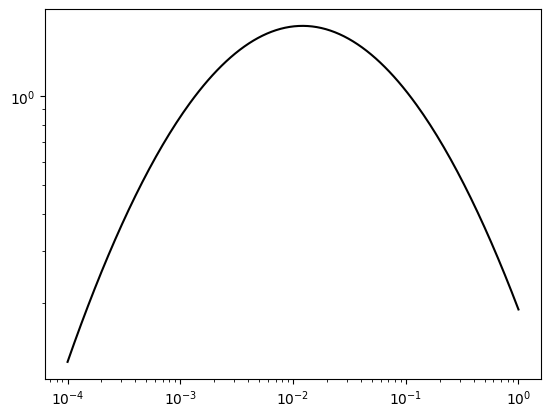

In [2]:
kk = np.logspace(-4, 0, 200)
pk = lognorm.pdf(kk, 2.1) 

plt.plot(kk, pk, 'k')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [3]:
sbt = SBT(to_fourier=False, ells=[0, 2])

In [4]:
xi = sbt.get_transform(kk, pk)

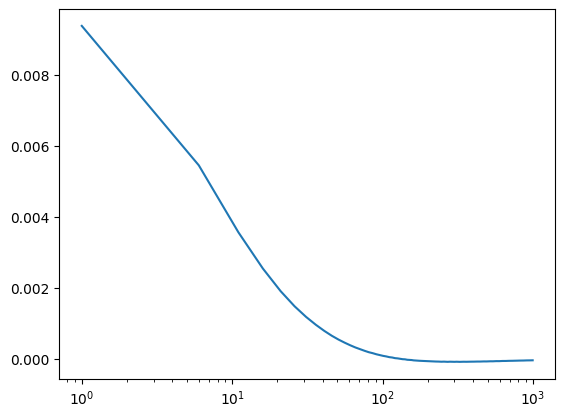

In [5]:
plt.plot(sbt.x, sbt.x**2 * xi[0])
plt.xscale('log')

### An end-to-end realistic example 
Choose options: 

In [6]:
ells = [0, 2]
sout = np.arange(1., 1e3, 5.) # can be made coarser/narrower depending on needs, trading accuracy for speed

sbt = SBT(to_fourier=False, ells=ells, 
         s=sout, kmin=1e-4, kmax=1e3, bias=.01, window=.2, # some useful options to play with to control ringing
          NFFT=256, # can be decreased to trade accuracy for speed (default: 512)
          mode='exact', # mode='exact' if the pk to fftlog is defined on the internal k's of SBT (otherwise default: mode='interp')
          extrap='extrap' # extrapolate if mode='interp'
         ) 

kk = sbt.fft.x # internal k's used for fftlog: if the pk to fftlog is defined on these, no internal interpolation -> large speed gain

Linear power spectrum from `CLASS`

In [7]:
from classy import Class

In [8]:
z = 1.

In [9]:
M = Class()
cosmo = {'omega_b': 0.02235, 'omega_cdm': 0.120, 'h': 0.675, 'ln10^{10}A_s': 3.044, 'n_s': 0.965}
M.set(cosmo)
M.set({'output': 'mPk', 'P_k_max_h/Mpc': 1000, 'z_max_pk': z})
M.compute()

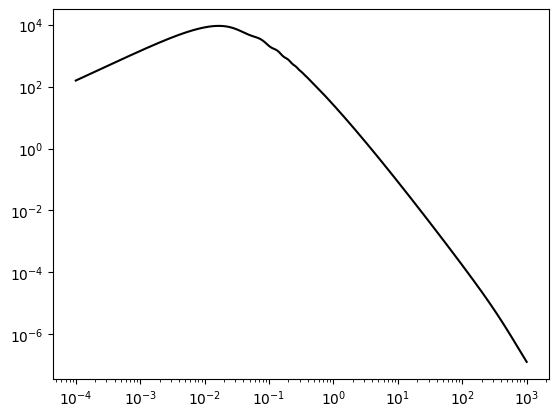

In [10]:
pk = np.array([M.pk_lin(k*M.h(), z)*M.h()**3 for k in kk]) 

plt.plot(kk, pk, 'k')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [11]:
xi = sbt.get_transform(kk, pk)

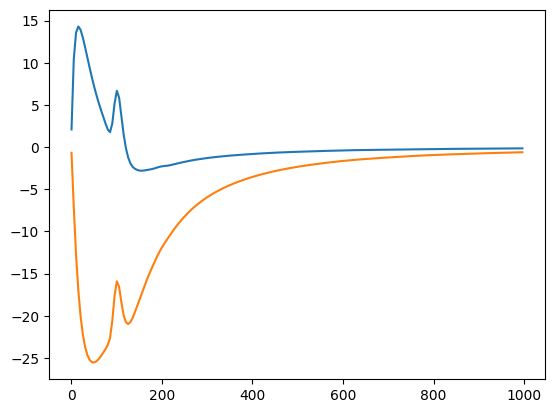

In [12]:
for i, ell in enumerate(ells): plt.plot(sout, sout**2 * xi[i])
# plt.xscale('log')

Speed?

In [13]:
%timeit for i in range(1000): xi = sbt.get_transform(kk, pk)

652 ms ± 63.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Parallel mode

In [14]:
# %time xi = sbt.get_transform(kk, 100*[[pk]])
%time xi = sbt.get_transform(kk, 1000*[pk])

CPU times: user 693 ms, sys: 299 ms, total: 992 ms
Wall time: 1.06 s


So the bottleneck is not the fftlog decomposition of $P$, but the matrix multiplication to get $\xi$...

jax mode

In [15]:
from fftlog.config import set_jax_enabled
set_jax_enabled(True)
from jax import jit
import jax.numpy as jnp

In [16]:
sbt = SBT(to_fourier=False, ells=ells, 
         s=sout, kmin=1e-4, kmax=1e3, bias=.01, window=.2, # some useful options to play with to control ringing
          NFFT=256, # can be decreased to trade accuracy for speed (default: 512)
          mode='exact', # mode='exact' if the pk to fftlog is defined on the internal k's of SBT (otherwise default: mode='interp')
          extrap='extrap' # extrapolate if mode='interp'
         ) 

In [17]:
get_transform_jit = jit(sbt.get_transform) # (kk, 100*[pk])
kk_, pk_ = jnp.array(kk), jnp.array(pk)

In [18]:
_ = get_transform_jit(kk, pk) # jitting

In [19]:
%timeit for i in range(1000): xi = get_transform_jit(kk, pk)

278 ms ± 31.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


jax parallel mode

In [20]:
%timeit xi = get_transform_jit(kk, 1000*[pk])

6.09 ms ± 2.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
